In [17]:
!pip install ase #Atomic Simulation Environment

import pandas as pd
import numpy as np
from ase.build import bulk
from tqdm import tqdm

# Load synthetic DFT dataset
df = pd.read_excel("/Fe Dataset DFT.xlsx")

In [18]:
def radial_symmetry_function(distances, eta_values=[0.05, 0.1, 0.2], Rs_values=[0, 0.5, 1.0]):
    #Compute a simple radial descriptor vector for an atom.
    #Each value is a Gaussian of distance to neighbors with parameters eta and Rs.
    descriptor = []
    for eta in eta_values:
        for Rs in Rs_values:
            descriptor.append(np.sum(np.exp(-eta * (distances - Rs)**2)))
    return np.array(descriptor)


In [19]:
all_descriptors = []
targets_thermal, targets_electrical, targets_magnetic = [], [], []

for _, row in tqdm(df.iterrows(), total=len(df)):
    # Build bcc Fe unit cell
    a = row['lattice_constant']
    atoms = bulk('Fe', 'bcc', a=a)
    positions = atoms.get_positions()

    descriptor_atoms = []
    for i in range(len(positions)):
        distances = np.linalg.norm(positions - positions[i], axis=1)
        distances = distances[distances > 0]  # remove self-distance
        descriptor_atoms.append(radial_symmetry_function(distances))

    # Average descriptors over all atoms in unit cell
    all_descriptors.append(np.mean(descriptor_atoms, axis=0))

    # Store target properties
    targets_thermal.append(row['thermal_conductivity'])
    targets_electrical.append(row['electrical_resistivity'])
    targets_magnetic.append(row['magnetic_moment'])

# Convert to numpy arrays and save
X = np.array(all_descriptors)
y_thermal = np.array(targets_thermal)
y_electrical = np.array(targets_electrical)
y_magnetic = np.array(targets_magnetic)

np.save("X_NNP.npy", X)
np.save("y_thermal.npy", y_thermal)
np.save("y_electrical.npy", y_electrical)
np.save("y_magnetic.npy", y_magnetic)


100%|██████████| 10000/10000 [00:04<00:00, 2383.45it/s]


In [20]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

# Stack targets for multi-output regression
y = np.vstack([y_thermal, y_electrical, y_magnetic]).T

class MLIPDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = MLIPDataset(X, y)

# Split into train/test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [21]:
import torch.nn as nn

class NNP(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.model(x)

model = NNP(X.shape[1])
criterion = nn.MSELoss()          # Mean Squared Error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [22]:
n_epochs = 50
for epoch in range(n_epochs):
    model.train()
    running_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(X_batch), y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)

    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {running_loss/len(train_loader.dataset):.4f}")


Epoch 1/50, Loss: 1996.9260
Epoch 2/50, Loss: 265.1720
Epoch 3/50, Loss: 24.4091
Epoch 4/50, Loss: 24.4271
Epoch 5/50, Loss: 24.4290
Epoch 6/50, Loss: 24.4111
Epoch 7/50, Loss: 24.4216
Epoch 8/50, Loss: 24.4397
Epoch 9/50, Loss: 24.4237
Epoch 10/50, Loss: 24.4123
Epoch 11/50, Loss: 24.4701
Epoch 12/50, Loss: 24.4317
Epoch 13/50, Loss: 24.4334
Epoch 14/50, Loss: 24.4247
Epoch 15/50, Loss: 24.4322
Epoch 16/50, Loss: 24.4579
Epoch 17/50, Loss: 24.4283
Epoch 18/50, Loss: 24.4207
Epoch 19/50, Loss: 24.4575
Epoch 20/50, Loss: 24.4467
Epoch 21/50, Loss: 24.4808
Epoch 22/50, Loss: 24.4736
Epoch 23/50, Loss: 24.4325
Epoch 24/50, Loss: 24.4668
Epoch 25/50, Loss: 24.4360
Epoch 26/50, Loss: 24.4740
Epoch 27/50, Loss: 24.4853
Epoch 28/50, Loss: 24.5073
Epoch 29/50, Loss: 24.4646
Epoch 30/50, Loss: 24.5720
Epoch 31/50, Loss: 24.5583
Epoch 32/50, Loss: 24.5314
Epoch 33/50, Loss: 24.4877
Epoch 34/50, Loss: 24.4583
Epoch 35/50, Loss: 24.5744
Epoch 36/50, Loss: 24.4739
Epoch 37/50, Loss: 24.5881
Epoch 3

In [23]:
model.eval()
test_loss = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        test_loss += criterion(model(X_batch), y_batch).item() * X_batch.size(0)

print(f"Test MSE Loss: {test_loss/len(test_loader.dataset):.4f}")


Test MSE Loss: 23.9704


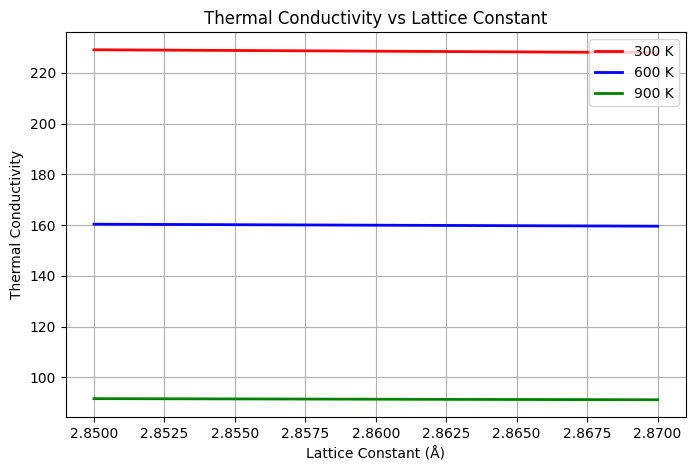

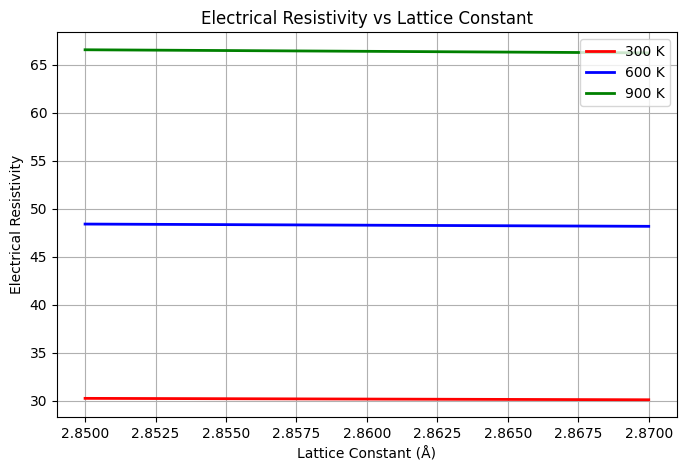

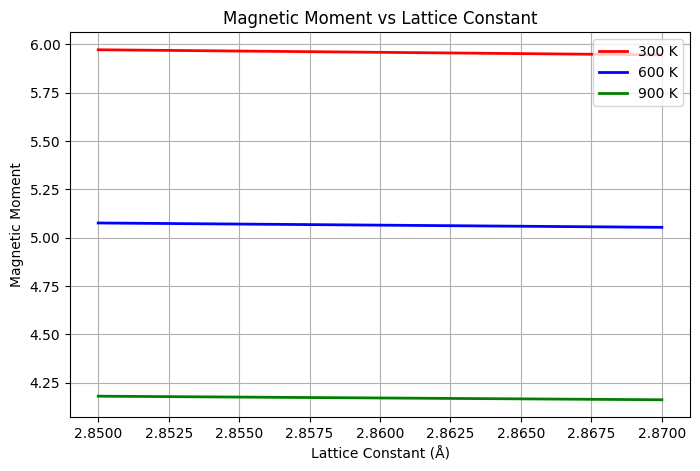

In [24]:
import matplotlib.pyplot as plt

temperatures = [300, 600, 900]
colors = ['red', 'blue', 'green']
lattice_constants = np.linspace(2.85, 2.87, 50)
predictions = { 'thermal': [], 'electrical': [], 'magnetic': [] }

# Predict properties for small variations in lattice constant
for T in temperatures:
    props_thermal, props_electrical, props_magnetic = [], [], []
    for a in lattice_constants:
        # Simplified descriptor
        distances = np.array([a]*8)
        descriptor = np.array([np.sum(np.exp(-eta*(distances-Rs)**2))
                               for eta in [0.05, 0.1, 0.2]
                               for Rs in [0, 0.5, 1.0]])
        X_input = torch.tensor(descriptor, dtype=torch.float32).unsqueeze(0)

        with torch.no_grad():
            y_pred = model(X_input).numpy()[0]

        # Apply approximate temperature trends
        props_thermal.append(y_pred[0]*(1 - 0.001*(T-300)))
        props_electrical.append(y_pred[1]*(1 + 0.002*(T-300)))
        props_magnetic.append(y_pred[2]*(1 - 0.0005*(T-300)))

    predictions['thermal'].append(props_thermal)
    predictions['electrical'].append(props_electrical)
    predictions['magnetic'].append(props_magnetic)

# Plot property trends
for i, prop in enumerate(['thermal', 'electrical', 'magnetic']):
    plt.figure(figsize=(8,5))
    for t_idx, T in enumerate(temperatures):
        plt.plot(lattice_constants, predictions[prop][t_idx], color=colors[t_idx], label=f'{T} K', linewidth=2)
    plt.xlabel('Lattice Constant (Å)')
    plt.ylabel(['Thermal Conductivity', 'Electrical Resistivity', 'Magnetic Moment'][i])
    plt.title(f"{['Thermal Conductivity', 'Electrical Resistivity', 'Magnetic Moment'][i]} vs Lattice Constant")
    plt.legend()
    plt.grid(True)
    plt.show()
